# Dom's Notebook

hypothesis:

(01/09/20)
- Taxo ID [7,8] fall into Exec and consult
- taxo ID [3,4,5,9] fall into specialists
- Taxo ID [1,2,6] are further divided by experience level
        - we weren't satisfied on the results of this grouping

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
import wrangle, explore
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import ttest_ind, chi2_contingency


In [2]:
data = pd.read_excel('/Users/dom/codeup_data_science/capstone/kev/survey_responses.xlsx', )
data.head(2)

,q00,q01a,q01b,q01c,q02a,q02b,q02c,q02d,q02e,q02f,...,q14,q15,q16,q17a,q17b,q18a,q21,q22,q23,q09a
0,284,Academic,4,1.0,Often,Neutral,Never,Often,Often,Often,...,NaN,NaN,"CHI, INTERACT",depending on the professional values,7.0,"any, depending on the values",research-practice connections,NaN,research-practice connections,"sort of, psychology background."
1,288,Academic,4,1.0,Occasionally,Neutral,Occasionally,Often,Often,Often,...,"Content, cost, timing (can I get away at this ...","Dagstuhl workshop - small, intense, intimate g...",Hawaii international conference on Education,I would attend any of these,6.0,Multi-track: Every attendee chooses their own ...,NaN,NaN,Don’t create schedule conflicts with other rel...,"Yes, I was taught how to conduct research"


In [3]:
data_dictionary = pd.read_excel('../data_files/data_dictionary.xlsx')
data_dictionary.head()

,qid,column_name,is_required,from_orig_file,in_wrangle,char_type,function,data_type,encoder,survey_section,question_group,question_text
0,q00,resp_id,True,True,True,numeric,identification,int64,NaN,Survey,ID,Entry Id
1,q01a,job_title,True,True,True,text,categorical,category,NaN,Work,Position,Title
2,q01b,job_taxo,True,True,True,numeric,categorical,category,NaN,Work,Position,Job Taxo ID
3,q01c,job_id,False,True,True,numeric,categorical,category,NaN,Work,Position,Job ID
4,q02a,job_conduct_res,True,True,True,numeric,quantitative,int64,often5,Work,Research Duties,Conducting Research


In [4]:
data.rename(columns = data_dictionary[['qid','column_name']].set_index('qid').column_name, inplace=True)
data.head(2)

,resp_id,job_title,job_taxo,job_id,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,...,how_pick_events,best_event,events_attend_recent,ideal_conference_size,ideal_conference_size_cat_orig,ideal_structure,ideal_topics,ideal_attendees,recommendations,research_educ
0,284,Academic,4,1.0,Often,Neutral,Never,Often,Often,Often,...,NaN,NaN,"CHI, INTERACT",depending on the professional values,7.0,"any, depending on the values",research-practice connections,NaN,research-practice connections,"sort of, psychology background."
1,288,Academic,4,1.0,Occasionally,Neutral,Occasionally,Often,Often,Often,...,"Content, cost, timing (can I get away at this ...","Dagstuhl workshop - small, intense, intimate g...",Hawaii international conference on Education,I would attend any of these,6.0,Multi-track: Every attendee chooses their own ...,NaN,NaN,Don’t create schedule conflicts with other rel...,"Yes, I was taught how to conduct research"


In [5]:
df,_ = wrangle.wrangle_data()
df.head()

,job_title,job_taxo,job_id,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,job_teach_res,...,session_workshop,session_network,session_social_event,session_qa,sesson_topic_tables,other_conference_types,ideal_topics,ideal_attendees,recommendations,persona_id
resp_id,,,,,,,,,,,,,,,,,,,,,
284,Academic,4,1.0,3,2,0,3,3,3,3,...,2,3,2,2,2,NaN,research-practice connections,NaN,research-practice connections,2
288,Academic,4,1.0,1,2,1,3,3,3,3,...,3,3,1,1,2,NaN,NaN,NaN,Don’t create schedule conflicts with other rel...,2
294,Academic,4,1.0,3,3,1,3,1,3,3,...,2,2,2,2,2,NaN,NaN,NaN,Looking forward! \n,2
281,Academic,4,1.0,3,4,0,2,3,2,0,...,3,2,2,3,2,NaN,"Research design, innovative methods, communica...",NaN,NaN,2
280,Academic,4,1.0,3,3,0,1,1,3,2,...,3,2,1,2,2,You should consider the combination of confere...,NaN,NaN,NaN,2


- Checking freds nlp functions

In [6]:
# sys.path.append('../fred')
# import nlp

In [7]:
# mat, vect = nlp.create_tfidf_matrix(df.best_event)

#### Exploration

In [8]:
#dataframe
df.head(2)

,job_title,job_taxo,job_id,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,job_teach_res,...,session_workshop,session_network,session_social_event,session_qa,sesson_topic_tables,other_conference_types,ideal_topics,ideal_attendees,recommendations,persona_id
resp_id,,,,,,,,,,,,,,,,,,,,,
284,Academic,4,1.0,3,2,0,3,3,3,3,...,2,3,2,2,2,NaN,research-practice connections,NaN,research-practice connections,2
288,Academic,4,1.0,1,2,1,3,3,3,3,...,3,3,1,1,2,NaN,NaN,NaN,Don’t create schedule conflicts with other rel...,2


In [9]:
#Quantitative columns
quant_cols = df.select_dtypes([int,float]).columns
quant_cols.to_list()

['job_conduct_res',
 'job_analyze_res',
 'job_buy_res_report',
 'job_manage_res_proj',
 'job_observe_res',
 'job_plan_res',
 'job_teach_res',
 'job_advocate_res',
 'job_hire_res_vendor',
 'job_lead_res_team',
 'company_small',
 'company_med',
 'company_large',
 'num_res_small',
 'num_res_med',
 'num_res_large',
 'exp_conduct_res',
 'exp_analyze_res',
 'exp_buy_res_report',
 'exp_manage_res_proj',
 'exp_observe_res',
 'exp_plan_res',
 'exp_teach_res',
 'exp_advocate_res',
 'exp_hire_res_vendor',
 'exp_lead_res_team',
 'research_educ_cat',
 'learning_talks',
 'learning_read',
 'learning_meetup',
 'learning_workshop',
 'learning_conference',
 'likely_watch_video',
 'likely_internet',
 'likely_book',
 'likely_online_group',
 'likely_colleague',
 'likely_meetup',
 'likely_conference',
 'likely_workshop',
 'factor_speaker',
 'factor_diverse_speak',
 'factor_topics',
 'factor_format_sessions',
 'factor_size',
 'factor_network',
 'factor_variety_attend',
 'factor_code',
 'factor_location',
 'f

In [10]:
#Jobs by taxo id
    #1 is UX researchers
    #2 is Developers
    #3 is Researcher/Scientist
    #4 is Academic/Students
    #5 is Planners?
    #6 is Design/Research Managers
    #7 is Consultans
    #8 is Executive
    #9 is misc
data.groupby(['job_taxo', 'job_title']).job_title.count()

job_taxo  job_title              
1         Principal UX Researcher     44
          Senior UX Researcher        97
          UX Researcher              202
2         Principal UX Designer       28
          Senior UX Designer          25
          UX Designer                 87
3         Analyst                      5
          Anthropologist               3
          Behavioral economist         1
          Ethnographer                 1
          Market Researcher            4
          Research Scientist           1
          Researcher                   9
4         Academic                    23
          Student                      5
5         Content Strategist           4
          Engineer                    14
          Information Architect       11
          Product Manager             10
          Service Designer            10
          Strategist                  25
6         Design Manager              65
          Research Manager            70
7         Consultant   

In [11]:
df.groupby(['persona_id','job_taxo']).persona_id.count()

persona_id  job_taxo
1           7            49
            8            45
2           3            23
            4            23
            5            65
            9            12
3           1           125
            2            22
            6            87
4           1           113
            2            47
            6            21
5           1            49
            2            40
            6             5
Name: persona_id, dtype: int64

In [12]:
df.persona_id.value_counts()

3    234
4    181
2    123
5     94
1     94
Name: persona_id, dtype: int64

In [13]:
exp_cols = ['exp_conduct_res', 'exp_analyze_res',
           'exp_buy_res_report', 'exp_manage_res_proj', 'exp_observe_res',
           'exp_plan_res', 'exp_teach_res', 'exp_advocate_res',
           'exp_hire_res_vendor', 'exp_lead_res_team']
df[exp_cols].mean(axis = 1)

resp_id
284    5.0
288    4.7
294    3.6
281    0.6
280    2.0
      ... 
869    0.6
879    1.0
136    2.4
74     1.5
2      1.3
Length: 726, dtype: float64

In [14]:
#show distributions of values


In [15]:
#establish features and target and split train and test data
def assign_target(x):
    group=0
    if x.learning_conference > 1:
        group += 1
    if x.likely_conference > 1:
        group += 1
    return group
df['target'] = df.apply(assign_target, axis = 1)

x = quant_cols.drop(['likely_conference','learning_conference', 'likely_workshop','learning_workshop']).to_list()+['persona_id', 'job_taxo']
y = 'target'
train, test = train_test_split(df[x+[y]].dropna(subset = [y]), stratify = df[y])

In [16]:
#1/14/20
#use svm or 
#form hypothesis and test them
df.target.value_counts()

2    372
1    202
0    152
Name: target, dtype: int64

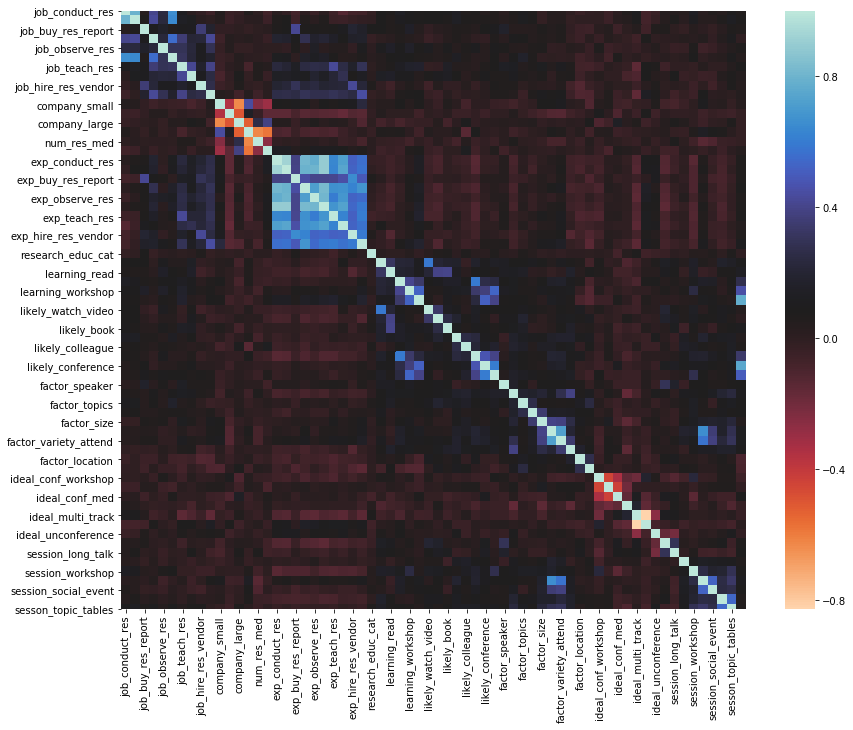

In [17]:
plt.figure(figsize=(14,11))
sns.heatmap(df.corr(), cmap = 'icefire_r')
plt.show()

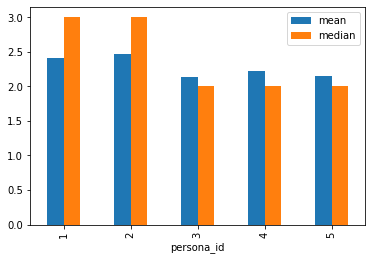

persona_id
1     94
2    123
3    234
4    181
5     94
Name: likely_conference, dtype: int64

In [18]:
df.groupby('persona_id').likely_conference.agg(['mean', 'median',]).plot.bar()
plt.show()
df.groupby('persona_id').likely_conference.count()

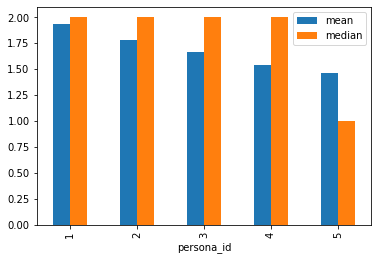

In [19]:
df.groupby('persona_id').learning_conference.agg(['mean', 'median']).plot.bar()
plt.show()


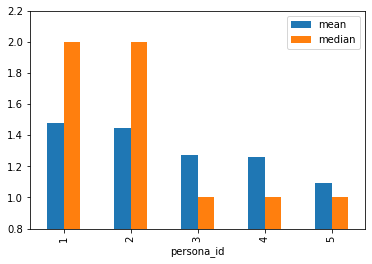

persona_id
1     94
2    123
3    234
4    181
5     94
Name: target, dtype: int64

In [20]:
df.groupby('persona_id').target.agg(['mean', 'median']).plot.bar()
plt.ylim(.8, 2.2)
plt.show()
df.groupby('persona_id').target.count()


Text(0.5, 1, 'Statistical difference between persona groups of likelyhood to attend a conference')

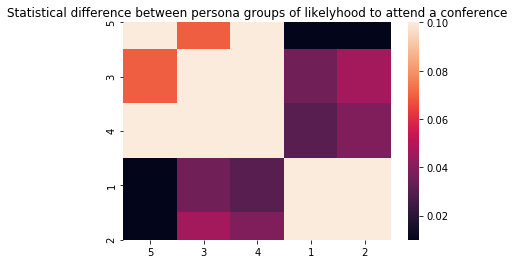

In [21]:
ttests = {}
row = {}
for i in df.persona_id.unique().sort_values(ascending = False):
    for j in df.persona_id.unique().sort_values(ascending = False):
        ttests[j] = ttest_ind(df[df.persona_id == i].target,df[(df.persona_id == j)].target, nan_policy='omit')[1]
    row[i] = ttests.copy()
sns.heatmap(pd.DataFrame(row), vmin = .01, vmax=.1)
plt.title('Statistical difference between persona groups of likelyhood to attend a conference')

In [22]:
pd.DataFrame(row)

,5,3,4,1,2
5,1.000000,0.069732,0.106383,0.001045,0.000890
3,0.069732,1.000000,0.861639,0.036130,0.046837
4,0.106383,0.861639,1.000000,0.030935,0.039179
1,0.001045,0.036130,0.030935,1.000000,0.761731
2,0.000890,0.046837,0.039179,0.761731,1.000000


After consideration, I have decided to scrap this model and opt to use chi squared tests to determine which features to eliminate

In [23]:
tree = DecisionTreeClassifier(max_depth=4, max_features=20, random_state=123)
tree.fit(train[x], train[y])
predicted = tree.predict(test[x]) 


In [24]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           0       0.17      0.05      0.08        38
           1       0.55      0.24      0.33        51
           2       0.55      0.87      0.67        93

    accuracy                           0.52       182
   macro avg       0.42      0.39      0.36       182
weighted avg       0.47      0.52      0.45       182



col_0,0,1,2
target,,,
0,2,6,30
1,2,12,37
2,8,4,81


[Text(158.43214285714285, 195.696, 'persona_id <= 2.5\ngini = 0.616\nsamples = 544\nvalue = [114, 151, 279]'),
 Text(77.72142857142858, 152.208, 'likely_meetup <= 1.5\ngini = 0.529\nsamples = 156\nvalue = [24, 33, 99]'),
 Text(47.82857142857143, 108.72, 'ideal_conf_med <= 0.5\ngini = 0.658\nsamples = 47\nvalue = [15, 13, 19]'),
 Text(23.914285714285715, 65.232, 'job_manage_res_proj <= 1.5\ngini = 0.635\nsamples = 41\nvalue = [15, 8, 18]'),
 Text(11.957142857142857, 21.744, 'gini = 0.5\nsamples = 14\nvalue = [1, 4, 9]'),
 Text(35.871428571428574, 21.744, 'gini = 0.598\nsamples = 27\nvalue = [14, 4, 9]'),
 Text(71.74285714285715, 65.232, 'job_conduct_res <= 0.5\ngini = 0.278\nsamples = 6\nvalue = [0, 5, 1]'),
 Text(59.785714285714285, 21.744, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(83.7, 21.744, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(107.61428571428571, 108.72, 'exp_conduct_res <= 0.5\ngini = 0.421\nsamples = 109\nvalue = [9, 20, 80]'),
 Text(95.65714285714286,

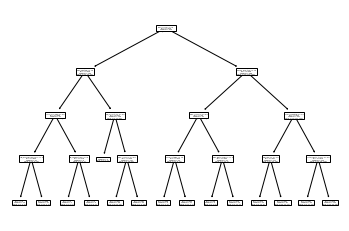

In [25]:
plot_tree(tree, feature_names=train[x].columns)

In [26]:
pd.DataFrame(tree.feature_importances_, index = train[x].columns)

,0
job_conduct_res,0.034323
job_analyze_res,0.000000
job_buy_res_report,0.000000
job_manage_res_proj,0.059735
job_observe_res,0.000000
...,...
session_social_event,0.000000
session_qa,0.000000
sesson_topic_tables,0.000000
persona_id,0.100388


In [27]:
reg = SVC(random_state=123)
reg.fit(train[x], train[y])
predicted = reg.predict(test[x])
r2 = reg.score(test[x], test[y])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [28]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           0       0.36      0.11      0.16        38
           1       0.57      0.08      0.14        51
           2       0.54      0.96      0.69        93

    accuracy                           0.53       182
   macro avg       0.49      0.38      0.33       182
weighted avg       0.51      0.53      0.43       182



col_0,0,1,2
target,,,
0,4,1,33
1,5,4,42
2,2,2,89


# MVP Model

In [29]:
df_mvp = df[['job_taxo', 'persona_id', 'num_employees']].join(pd.DataFrame(df[['exp_conduct_res']].apply(max, axis = 1), columns = ['experience']),).dropna()

In [30]:
#one hot encode for job taxos
df_mvp_ohe = pd.get_dummies(df_mvp, columns=['job_taxo']) 

In [31]:
x = df_mvp_ohe.drop(columns=['persona_id']).columns.to_list()
y = 'persona_id'
train, test = train_test_split(df_mvp_ohe, random_state = 123, stratify = df_mvp_ohe.persona_id)

In [32]:
classifier = SVC(random_state=123)
classifier.fit(train[x], train[y])
predicted = classifier.predict(test[x])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [33]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        24

    accuracy                           1.00       181
   macro avg       1.00      1.00      1.00       181
weighted avg       1.00      1.00      1.00       181



col_0,1,2,3,4,5
persona_id,,,,,
1,23,0,0,0,0
2,0,31,0,0,0
3,0,0,58,0,0
4,0,0,0,45,0
5,0,0,0,0,24


In [34]:
tree = DecisionTreeClassifier(random_state=123)
tree.fit(train[x], train[y])
predicted = tree.predict(test[x]) 

In [35]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        24

    accuracy                           1.00       181
   macro avg       1.00      1.00      1.00       181
weighted avg       1.00      1.00      1.00       181



col_0,1,2,3,4,5
persona_id,,,,,
1,23,0,0,0,0
2,0,31,0,0,0
3,0,0,58,0,0
4,0,0,0,45,0
5,0,0,0,0,24


### Explore groups

In [36]:
df.groupby(['persona_id','job_title']).job_taxo.count()

persona_id  job_title              
1           Consultant                 49
            Executive                  45
2           Academic                   20
            Analyst                     5
            Anthropologist              3
            Author                      1
            Behavioral economist        1
            Content Strategist          4
            Engineer                   13
            Ethnographer                1
            Information Architect      10
            Intern                      5
            Market Researcher           3
            Operations                  5
            Product Manager             7
            Research Scientist          1
            Researcher                  9
            Service Designer           10
            Strategist                 21
            Student                     3
            Writer                      1
3           Design Manager             38
            Principal UX Designer       

In [37]:
df.groupby(['persona_id','num_employees'], ).job_taxo.count()

persona_id  num_employees
1           0.0               62
            1.0                6
            2.0                9
            3.0                1
            4.0               15
2           0.0               31
            1.0               14
            2.0               20
            3.0               10
            4.0               47
3           0.0               35
            1.0               18
            2.0               24
            3.0               20
            4.0              136
4           0.0               15
            1.0               17
            2.0               30
            3.0               19
            4.0              100
5           0.0               14
            1.0               15
            2.0               14
            3.0               10
            4.0               41
Name: job_taxo, dtype: int64

In [38]:
df.groupby(['persona_id','session_network']).job_taxo.count()

persona_id  session_network
1           0                   7
            1                  15
            2                  16
            3                  23
            4                  33
2           0                  12
            1                  28
            2                  31
            3                  33
            4                  19
3           0                  26
            1                  48
            2                  56
            3                  73
            4                  31
4           0                  14
            1                  55
            2                  51
            3                  47
            4                  14
5           0                   9
            1                  21
            2                  24
            3                  21
            4                  19
Name: job_taxo, dtype: int64

In [39]:
df.groupby(['persona_id','factor_speaker']).job_taxo.count()

persona_id  factor_speaker
1           0                  7
            1                 20
            2                 16
            3                 39
            4                 12
2           0                  8
            1                 33
            2                 19
            3                 45
            4                 18
3           0                 18
            1                 48
            2                 47
            3                 99
            4                 22
4           0                 14
            1                 43
            2                 38
            3                 64
            4                 22
5           0                  7
            1                 26
            2                 20
            3                 27
            4                 14
Name: job_taxo, dtype: int64

In [40]:
df.groupby(['persona_id','factor_diverse_speak']).job_title.count()

persona_id  factor_diverse_speak
1           0                         5
            1                         9
            2                        15
            3                        38
            4                        27
2           0                         7
            1                        14
            2                        19
            3                        45
            4                        38
3           0                         9
            1                        20
            2                        36
            3                       106
            4                        63
4           0                         6
            1                        10
            2                        22
            3                        71
            4                        72
5           0                         3
            1                         8
            2                        14
            3                        44
       

In [41]:
df.groupby('persona_id').job_title.count()

persona_id
1     94
2    123
3    234
4    181
5     94
Name: job_title, dtype: int64

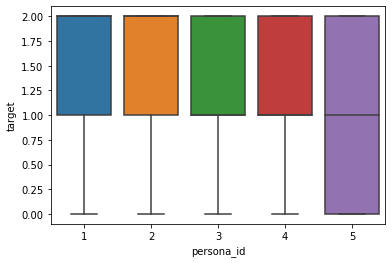

In [42]:
sns.boxplot(x = df.persona_id, y= df.target)

In [43]:
df.columns

Index(['job_title', 'job_taxo', 'job_id', 'job_conduct_res', 'job_analyze_res',
       'job_buy_res_report', 'job_manage_res_proj', 'job_observe_res',
       'job_plan_res', 'job_teach_res', 'job_advocate_res',
       'job_hire_res_vendor', 'job_lead_res_team', 'num_employees',
       'company_small', 'company_med', 'company_large', 'num_researchers',
       'num_res_small', 'num_res_med', 'num_res_large', 'primary_industry',
       'types_res_used', 'future_res', 'exp_conduct_res', 'exp_analyze_res',
       'exp_buy_res_report', 'exp_manage_res_proj', 'exp_observe_res',
       'exp_plan_res', 'exp_teach_res', 'exp_advocate_res',
       'exp_hire_res_vendor', 'exp_lead_res_team', 'research_educ',
       'research_educ_cat', 'research_educ_desc', 'learning_talks',
       'learning_read', 'learning_meetup', 'learning_workshop',
       'learning_conference', 'likely_watch_video', 'likely_internet',
       'likely_book', 'likely_online_group', 'likely_colleague',
       'likely_meetup', 'l

In [44]:
df.num_employees

resp_id
284    0.0
288    4.0
294    4.0
281    2.0
280    NaN
      ... 
869    3.0
879    2.0
136    4.0
74     4.0
2      2.0
Name: num_employees, Length: 726, dtype: category
Categories (5, float64): [0.0, 1.0, 2.0, 3.0, 4.0]

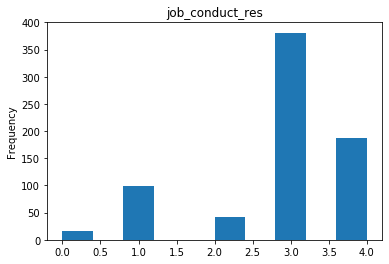

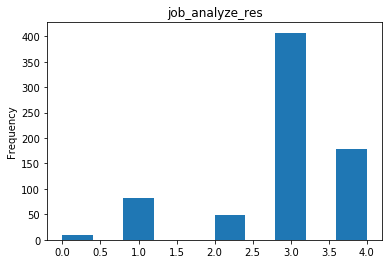

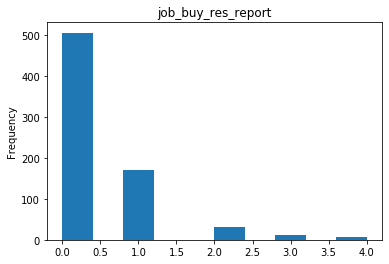

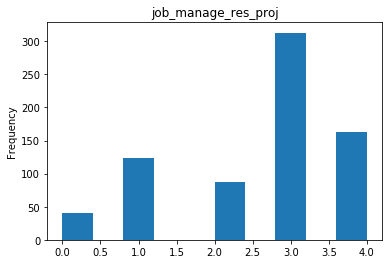

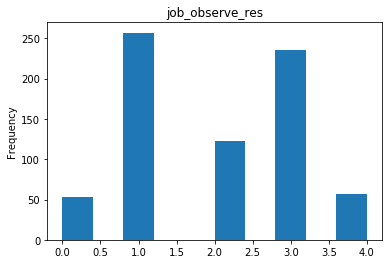

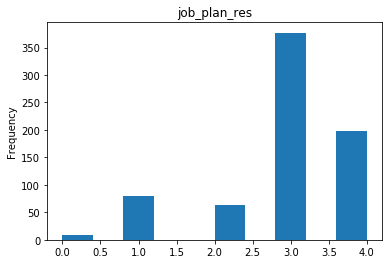

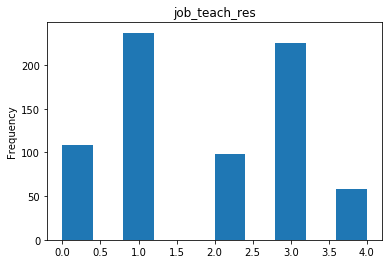

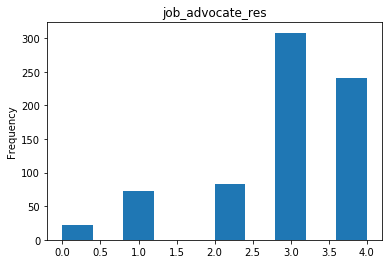

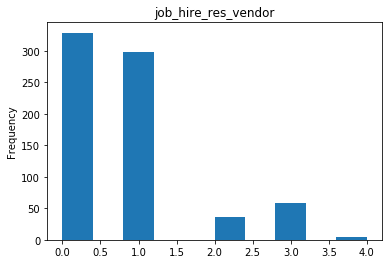

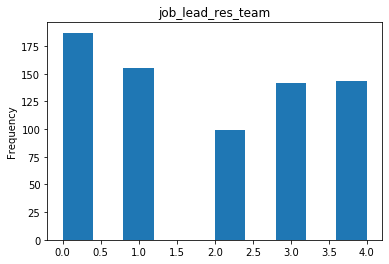

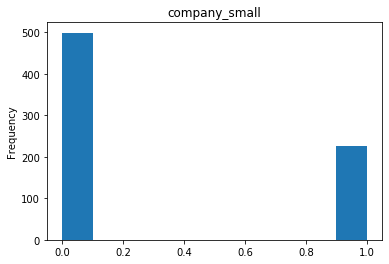

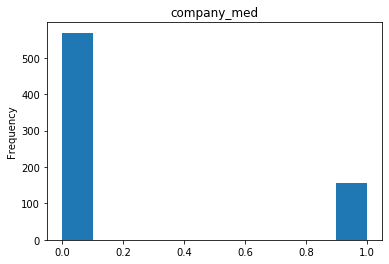

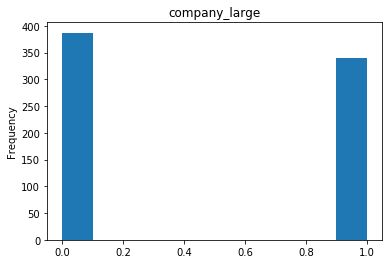

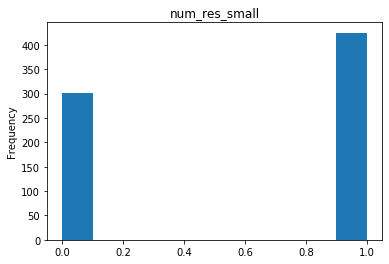

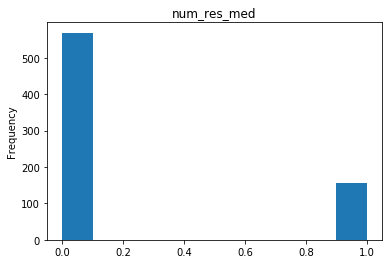

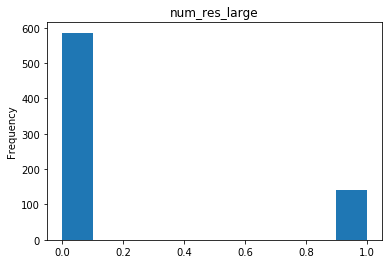

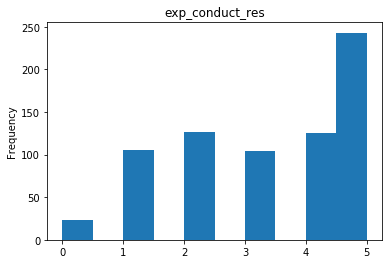

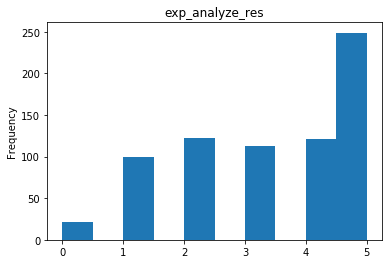

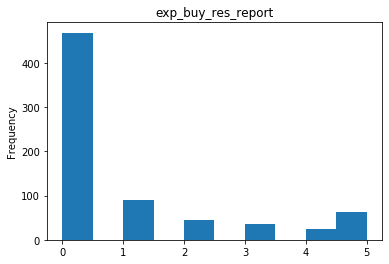

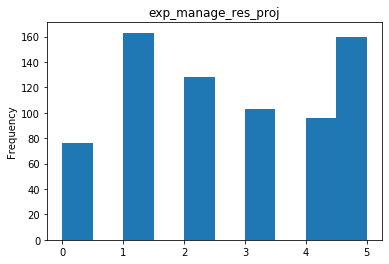

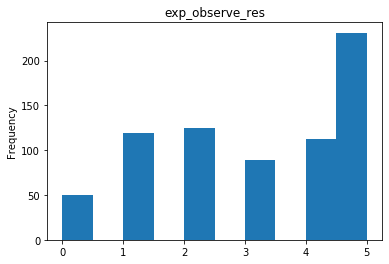

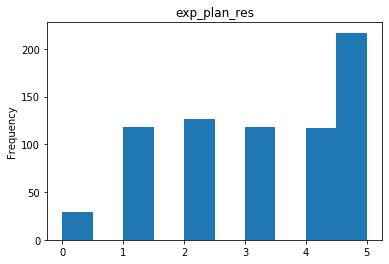

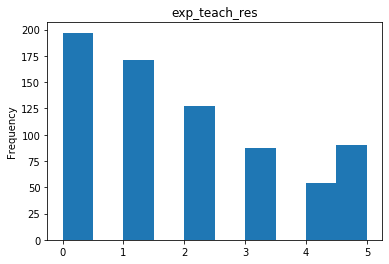

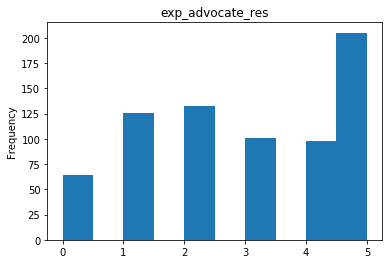

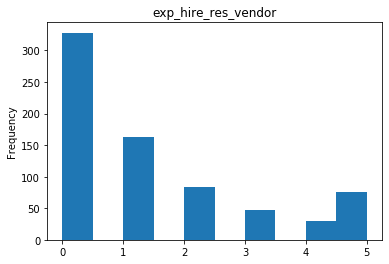

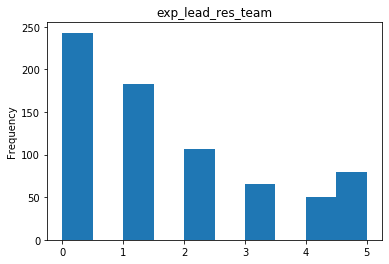

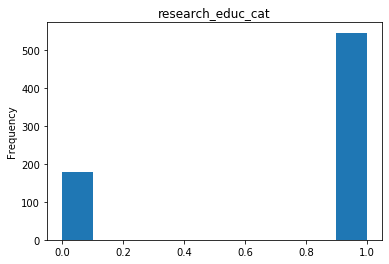

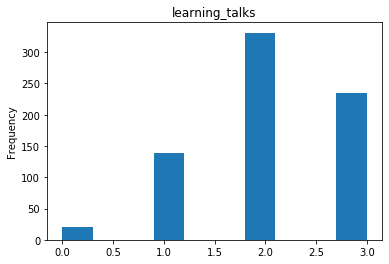

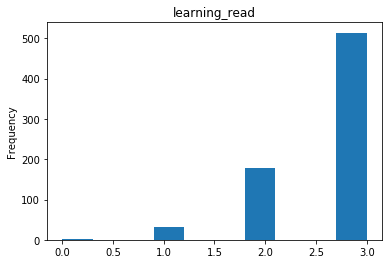

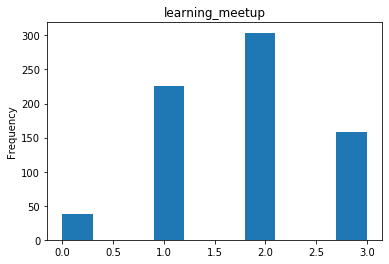

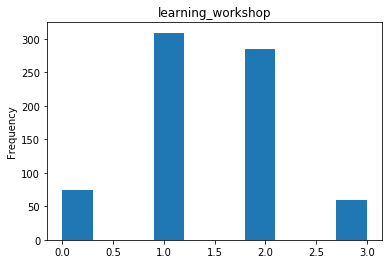

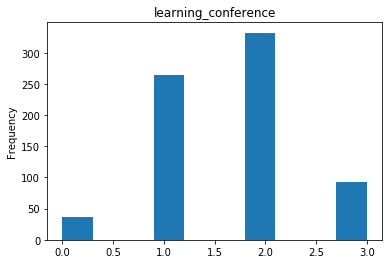

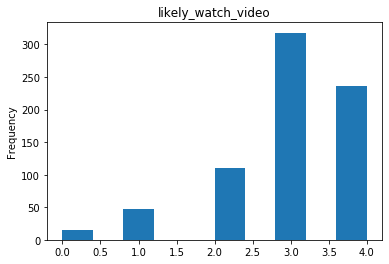

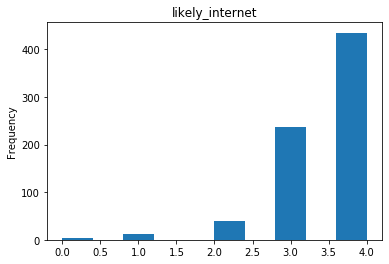

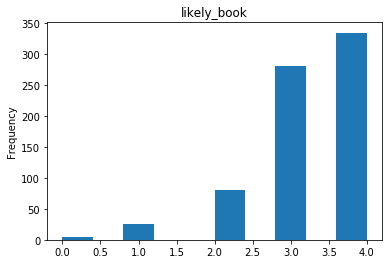

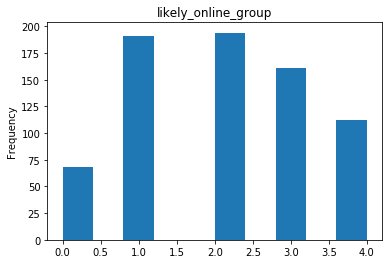

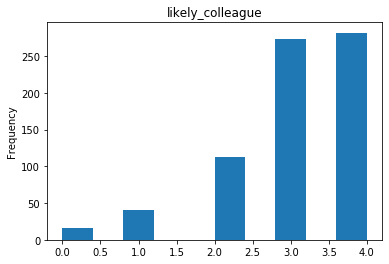

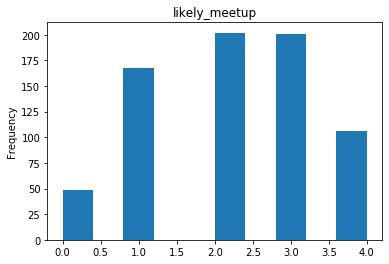

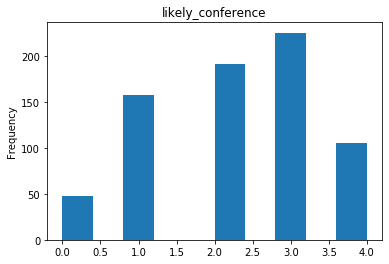

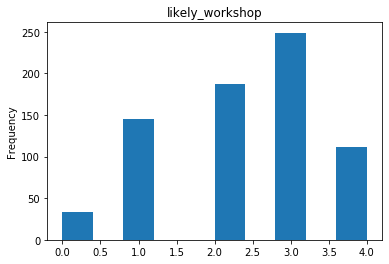

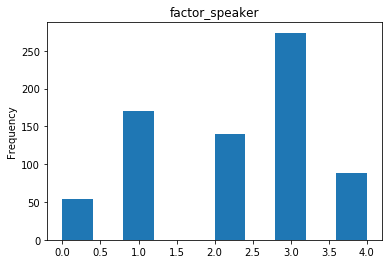

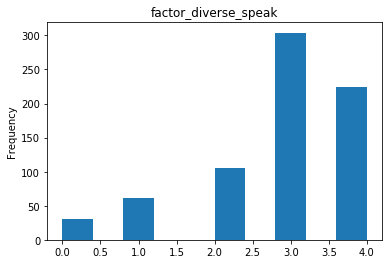

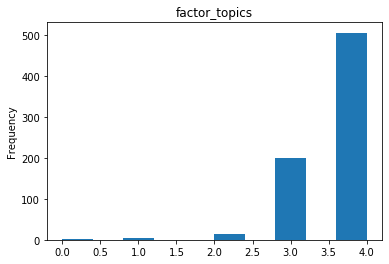

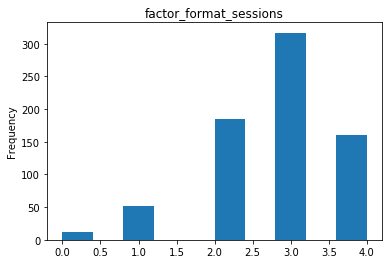

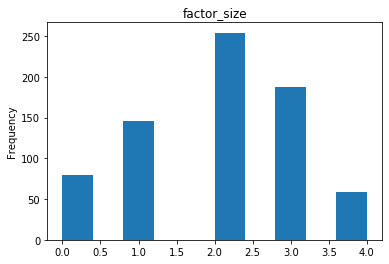

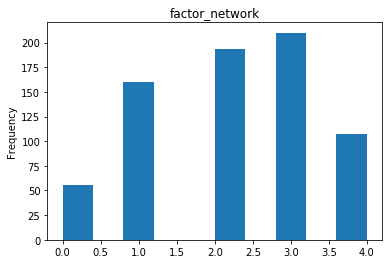

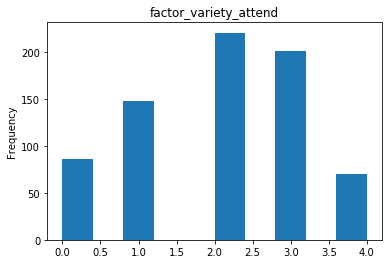

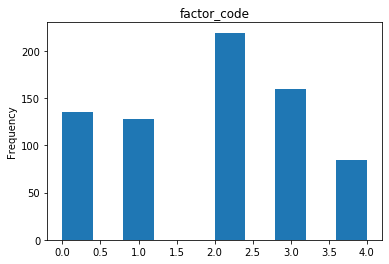

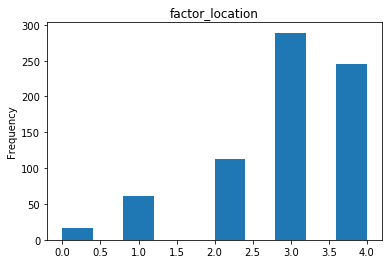

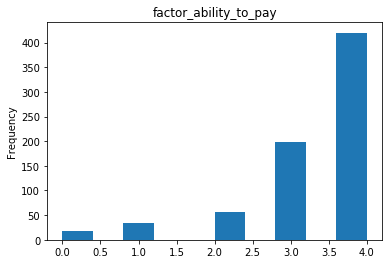

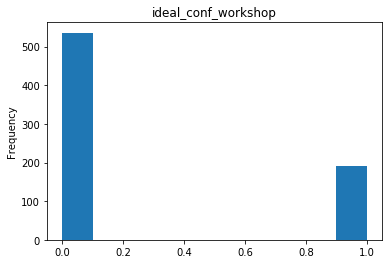

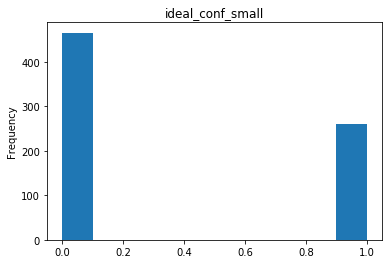

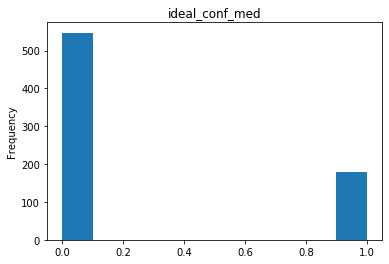

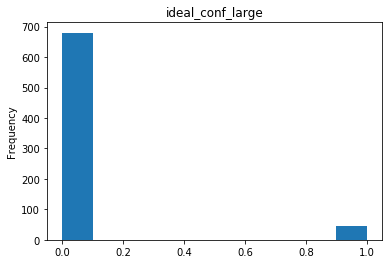

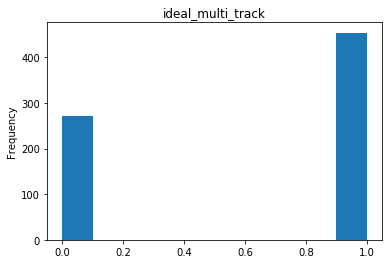

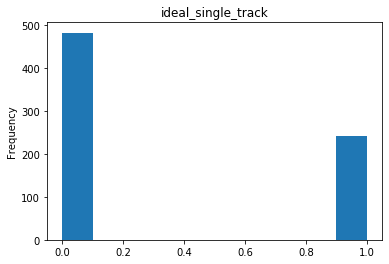

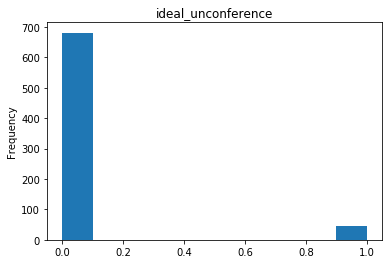

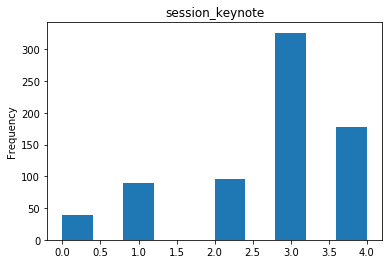

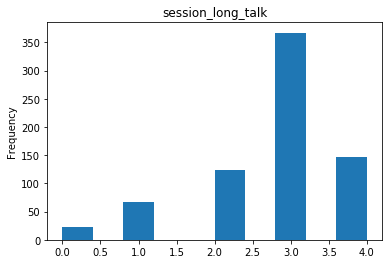

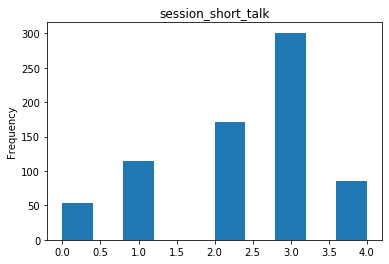

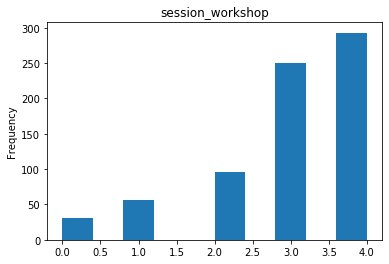

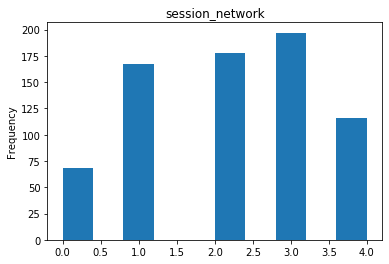

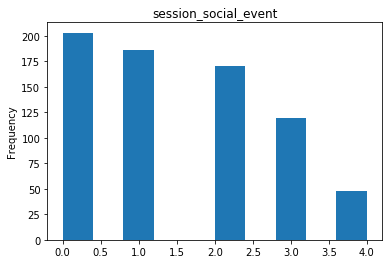

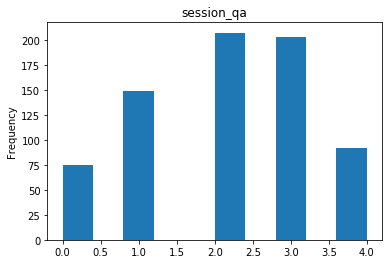

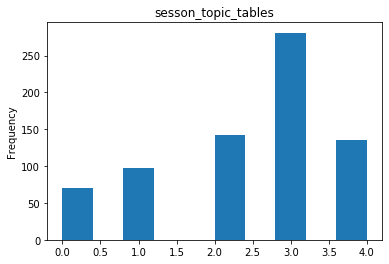

In [45]:
for i in quant_cols:
    df[i].plot.hist()
    plt.title(i)
    plt.show()

In [46]:
df.persona_id.unique()

[2, 1, 4, 3, 5]
Categories (5, int64): [2, 1, 4, 3, 5]

In [47]:
df.target.value_counts()

2    372
1    202
0    152
Name: target, dtype: int64

In [48]:
df.persona_id.value_counts()/df.persona_id.count()

3    0.322314
4    0.249311
2    0.169421
5    0.129477
1    0.129477
Name: persona_id, dtype: float64

In [49]:
def pct_trained_in_research(df, persona_column = 'persona_id'):
    pass
    

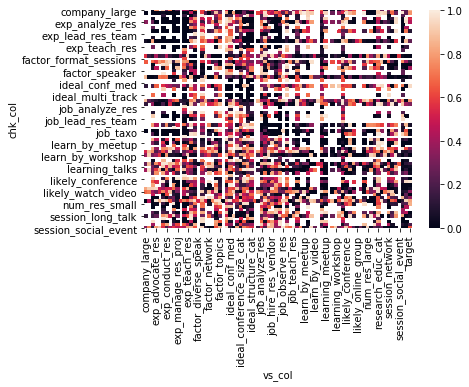

In [50]:
chi2 = pd.read_csv('../kev/chi2_2dfall.txt', index_col='index')
sns.heatmap(pd.crosstab(index = chi2.chk_col, columns=chi2.vs_col,values = chi2.p_val, aggfunc='median'))

In [51]:
chi2_row = {}
chi2_df = {}
for i in quant_cols:
    for j in quant_cols:
        observations = pd.crosstab(index = df[i], columns = df[j])
        chi2_row[j] = chi2_contingency(observations)[1]
    chi2_df[i] = chi2_row.copy()
chi2_df = pd.DataFrame(chi2_df)

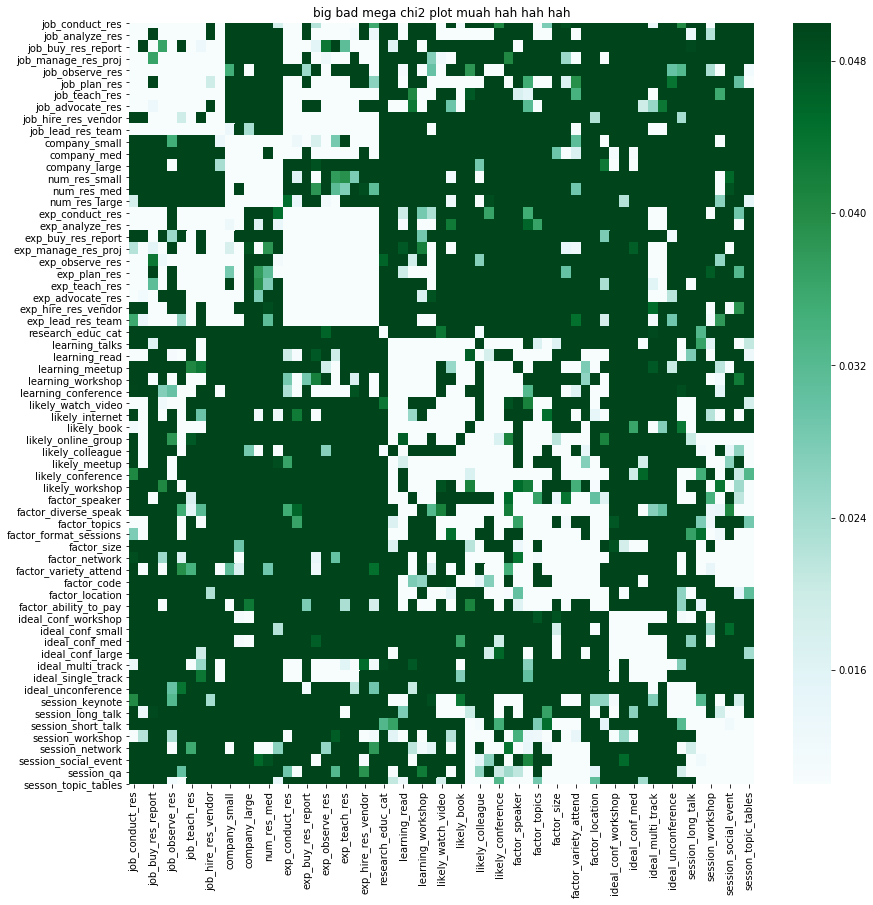

In [52]:
plt.figure(figsize=(14,14))
sns.heatmap(chi2_df,cmap = 'BuGn', vmax=.05, vmin=.01)
plt.title('big bad mega chi2 plot muah hah hah hah')
plt.show()

Text(0.5, 1, 'How much is your current job devoted to...')

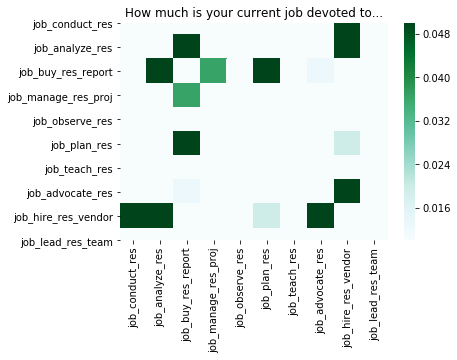

In [53]:
job_qs  = ['job_conduct_res', 'job_analyze_res', 'job_buy_res_report',
           'job_manage_res_proj', 'job_observe_res', 'job_plan_res',
           'job_teach_res', 'job_advocate_res', 'job_hire_res_vendor',
           'job_lead_res_team',]
sns.heatmap(chi2_df.loc[job_qs,job_qs],cmap = 'BuGn', vmax=.05, vmin=.01)
plt.title('How much is your current job devoted to...')

Text(0.5, 1, 'How much experience do you have with...')

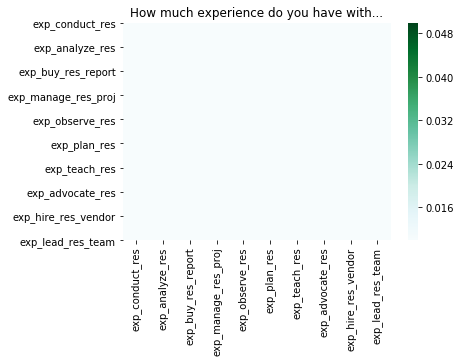

In [54]:
exp_qs  = ['exp_conduct_res', 'exp_analyze_res',
           'exp_buy_res_report', 'exp_manage_res_proj', 'exp_observe_res',
           'exp_plan_res', 'exp_teach_res', 'exp_advocate_res',
           'exp_hire_res_vendor', 'exp_lead_res_team',]
sns.heatmap(chi2_df.loc[exp_qs,exp_qs],cmap = 'BuGn', vmax=.05, vmin=.01)
plt.title('How much experience do you have with...')

Text(0.5, 1, 'How much experience do you have with...')

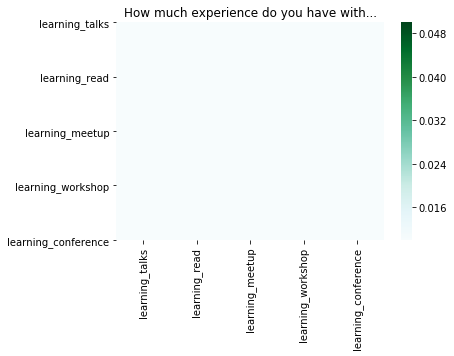

In [55]:
learning_qs = ['learning_talks',
               'learning_read', 'learning_meetup', 'learning_workshop',
               'learning_conference']
sns.heatmap(chi2_df.loc[learning_qs,learning_qs],cmap = 'BuGn', vmax=.05, vmin=.01)
plt.title('How much experience do you have with...')

Text(0.5, 1, 'How much experience do you have with...')

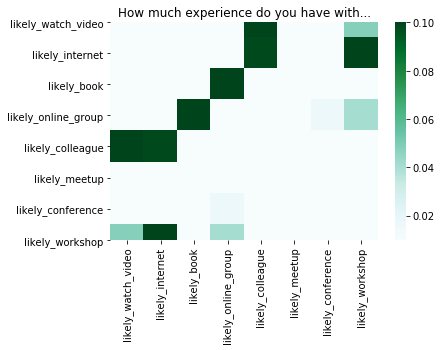

In [56]:
likely_qs  =  ['likely_watch_video', 'likely_internet',
               'likely_book', 'likely_online_group', 'likely_colleague',
               'likely_meetup', 'likely_conference', 'likely_workshop',]
sns.heatmap(chi2_df.loc[likely_qs,likely_qs],cmap = 'BuGn', vmax=.1, vmin=.01)
plt.title('How much experience do you have with...')

Text(0.5, 1, 'factor questions')

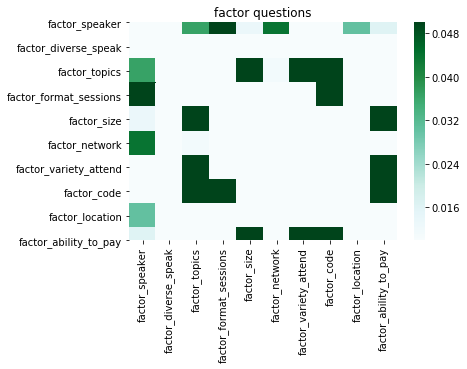

In [57]:
factors = ['factor_speaker', 'factor_diverse_speak', 'factor_topics', 
           'factor_format_sessions', 'factor_size', 'factor_network', 
           'factor_variety_attend', 'factor_code', 'factor_location', 
           'factor_ability_to_pay']
sns.heatmap(chi2_df.loc[factors,factors],cmap = 'BuGn', vmax=.05, vmin=.01)
plt.title('factor questions')

Text(0.5, 1, 'most important session types')

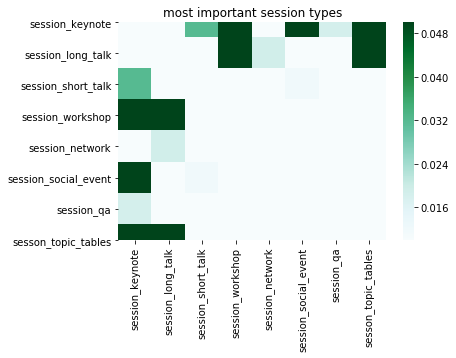

In [58]:
session_qs  = ['session_keynote', 'session_long_talk',
               'session_short_talk', 'session_workshop', 'session_network',
               'session_social_event', 'session_qa', 'sesson_topic_tables']
sns.heatmap(chi2_df.loc[session_qs,session_qs],cmap = 'BuGn', vmax=.05, vmin=.01)
plt.title('most important session types')

In [59]:
for i in df.persona_id.unique():
    print(df[df.persona_id == i].factor_speaker.value_counts().sort_index(),f'[{i}]')

0     8
1    33
2    19
3    45
4    18
Name: factor_speaker, dtype: int64 [2]
0     7
1    20
2    16
3    39
4    12
Name: factor_speaker, dtype: int64 [1]
0    14
1    43
2    38
3    64
4    22
Name: factor_speaker, dtype: int64 [4]
0    18
1    48
2    47
3    99
4    22
Name: factor_speaker, dtype: int64 [3]
0     7
1    26
2    20
3    27
4    14
Name: factor_speaker, dtype: int64 [5]


In [60]:
def encode_factor_speaker(x):
    if x == 0:
        return 0
    elif x == 1 or x == 2:
        return 1
    elif x == 3:
        return 2
    elif x == 4:
        return 3
    return x

In [61]:
for i in df.persona_id.unique():
    print(f'[ {i} ]')
    print(df[df.persona_id == i].factor_diverse_speak.apply(encode_factor_speaker).value_counts().sort_index(),)

[ 2 ]
0     7
1    33
2    45
3    38
Name: factor_diverse_speak, dtype: int64
[ 1 ]
0     5
1    24
2    38
3    27
Name: factor_diverse_speak, dtype: int64
[ 4 ]
0     6
1    32
2    71
3    72
Name: factor_diverse_speak, dtype: int64
[ 3 ]
0      9
1     56
2    106
3     63
Name: factor_diverse_speak, dtype: int64
[ 5 ]
0     3
1    22
2    44
3    25
Name: factor_diverse_speak, dtype: int64


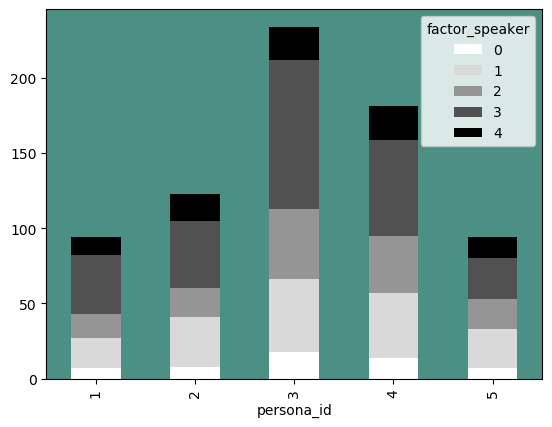

In [123]:
pd.crosstab(df.persona_id, df.factor_speaker,).plot(kind = 'bar', stacked = True, cmap = 'Greys').set_facecolor('xkcd:dusty teal')


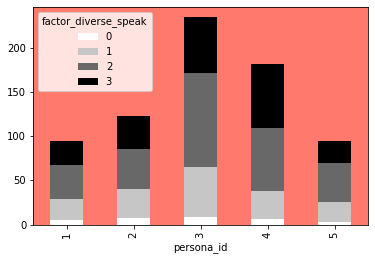

In [63]:
pd.crosstab(df.persona_id, df.factor_diverse_speak.apply(encode_factor_speaker),).plot(kind = 'bar', stacked = True, cmap = 'Greys').set_facecolor('xkcd:salmon')

In [64]:
matrix = pd.crosstab(df.factor_network.apply(encode_factor_speaker),df.persona_id, )
# .plot(kind = 'bar', stacked = True, cmap = 'Greys').set_facecolor('xkcd:salmon')
for i in matrix:
    matrix[i] = matrix[i]/sum(matrix[i])
matrix

persona_id,1,2,3,4,5
factor_network,,,,,
0,0.063830,0.073171,0.072650,0.071823,0.117021
1,0.372340,0.471545,0.504274,0.574586,0.404255
2,0.340426,0.268293,0.290598,0.259669,0.319149
3,0.223404,0.186992,0.132479,0.093923,0.159574


In [65]:
def create_stacked_bars(df, factor, return_matrix = False, grouping = 'persona_id'):
    matrix = pd.crosstab(df[factor].apply(encode_factor_speaker),df[grouping],)
    for i in matrix:
        matrix[i] = matrix[i]/sum(matrix[i])
    ax = matrix.transpose().plot(kind = 'barh', stacked = True, cmap = 'Greys')
    ax.set_facecolor('xkcd:light grey')
    plt.title(factor)
    plt.legend().remove()
    plt.ylabel(' ')
    plt.xticks([],[])
    plt.yticks([0,1,2,3,4],['Exec & Consult', 'Specialist','High Experience','Mid Experience','Low Experience'])
    plt.show()
    if return_matrix is True:
        return matrix


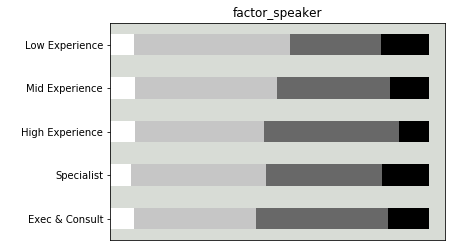

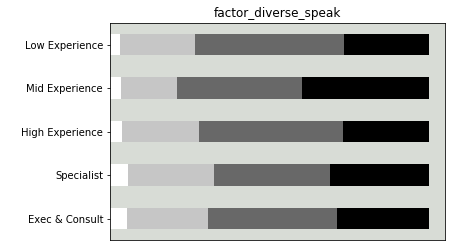

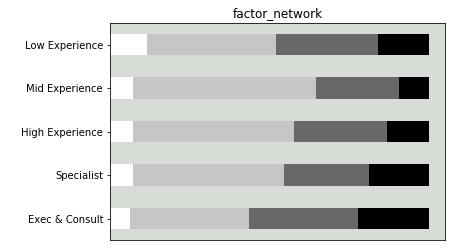

In [66]:
matricies = {}
j = 0
for i in ['factor_speaker','factor_diverse_speak','factor_network']:
    matricies[j] = create_stacked_bars(df, i, return_matrix=True)
    j += 1


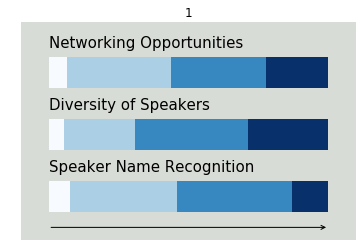

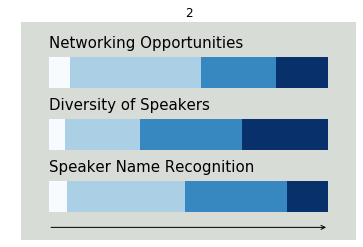

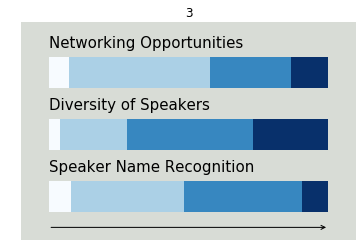

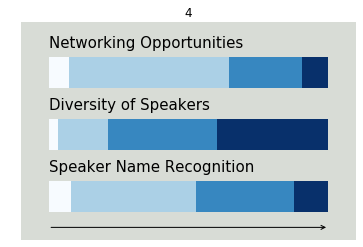

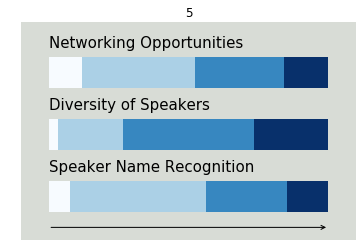

In [67]:
persona = {}
all_personas = {}
titles = ['Execs/Consult', 'Specialists', 'Very Expd', 'Med Expd', 'Less Expd']
for j in range(1,6):
    for i in [0,1,2]:
        persona[matricies[i].index.name] = matricies[i][j]
    all_personas[j] = pd.DataFrame(persona.copy())
for dataframe in all_personas.keys():
    ax = all_personas[dataframe].transpose().plot(kind = 'barh', stacked = True, cmap = 'Blues')
    ax.set_facecolor('xkcd:light grey')
    plt.title(dataframe)
    plt.legend().remove()
    plt.ylabel(' ')
    plt.xticks([],[])
    plt.annotate('Networking Opportunities', (0,2.4), fontsize=15)
    plt.annotate('Diversity of Speakers', (0,1.4), fontsize=15)
    plt.annotate('Speaker Name Recognition',(0,.4),fontsize=15)
    plt.annotate('',xy=(1 , -.5), xycoords='data',
                    xytext=(0, -.5), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3"))
    plt.yticks([],[])
    plt.ylim(-.7,2.8)
    plt.xlim(-.1,1.1)
    sns.despine(left=True, bottom=True, right=True)

    plt.savefig(f'/Users/dom/codeup_data_science/capstone/viz_files/their_personas/{dataframe}_stacked_bars', transparent = True)

In [68]:
idx = pd.IndexSlice
persona_counts = (pd.DataFrame(df
                               .groupby(by=['persona_id'])
                               .target
                               .agg('count')
                              )
                  .rename(columns={'target': 'count'})
                 )
job_group_by = ['persona_id', 'job_title']
job_counts = (pd.DataFrame(df
                           .groupby(by=job_group_by)
                           .target
                           .agg('count')
                          )
              .reset_index()
              .rename(columns={'target': 'count'})
              .sort_values(by=['persona_id','count'], ascending=[True,False]))
job_counts = job_counts.merge(
    persona_counts.rename(columns={'count':'total'}), 
    how='left', left_on='persona_id', right_on='persona_id')
job_counts['pid_pct'] = np.array(job_counts['count'])/np.array(job_counts['total'])
job_counts = job_counts.drop(columns='total')
job_counts = job_counts.set_index(['persona_id', 'job_title'])
for p in persona_counts.index:
    jc = job_counts.loc[idx[[p],:]].head(3).copy()
    display(jc)

count   pid_pct
persona_id job_title                  
1          Consultant     49  0.521277
           Executive      45  0.478723

count   pid_pct
persona_id job_title                  
2          Strategist     21  0.170732
           Academic       20  0.162602
           Engineer       13  0.105691

count   pid_pct
persona_id job_title                            
3          Senior UX Researcher     53  0.226496
           UX Researcher            50  0.213675
           Research Manager         49  0.209402

count   pid_pct
persona_id job_title                            
4          UX Researcher            73  0.403315
           Senior UX Researcher     26  0.143646
           UX Designer              23  0.127072

count   pid_pct
persona_id job_title                          
5          UX Researcher          44  0.468085
           UX Designer            34  0.361702
           Senior UX Designer      4  0.042553

In [69]:
jc.pid_pct.max()*1.1

0.5148936170212767

Execs_Consult
Specialists
Very_Expd
Med_Expd
Less_Expd


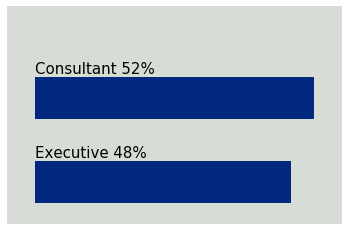

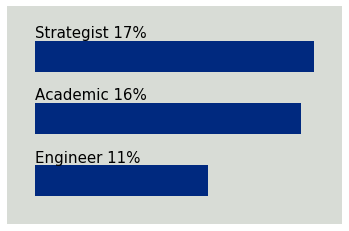

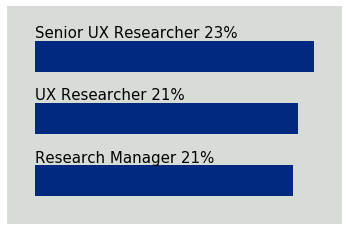

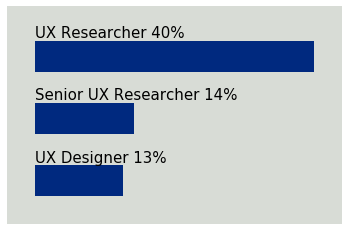

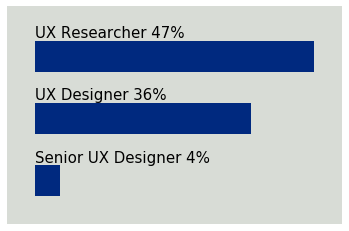

In [70]:
titles = ['Execs_Consult', 'Specialists', 'Very_Expd', 'Med_Expd', 'Less_Expd']

# Consultant Job Titles
print(titles[0])
jc = job_counts.loc[idx[[1],:]].head(3).copy()
jc=jc.reset_index().sort_values(by='pid_pct')
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.barh(jc.job_title, width=jc.pid_pct, height=.5, tick_label = jc.job_title, color = '#00297f')
ax1.set_facecolor('xkcd:light grey')
pcts = [int(round(jc["pid_pct"][0]*100)), int(round(jc["pid_pct"][1]*100))]
plt.annotate(f'Consultant {pcts[0]}%', (0,1.3), fontsize = 15)
plt.annotate(f'Executive {pcts[1]}%'  ,(0,.3), fontsize = 15)
plt.ylim(-.5,2.1)
plt.xlim(-.1*jc.pid_pct.max(), jc.pid_pct.max()*1.1)
plt.yticks([],[])
plt.xticks([],[])
sns.despine(left=True, bottom=True, right=True)

plt.savefig(f'/Users/dom/codeup_data_science/capstone/viz_files/their_personas/{titles[0]}_titles.png', transparent = True)

# Everyone Else Job Titles
for i in range(2,6):
    print(titles[i-1])
    persona_titles = []
    jc = job_counts.loc[idx[[i],:]].head(3).copy()
    jc = jc.reset_index().sort_values(by='pid_pct')
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.barh(jc.job_title, width=jc.pid_pct, height=.5, tick_label = jc.job_title, color = '#00297f')
    ax1.set_facecolor('xkcd:light grey')
    pcts = [int(round(jc["pid_pct"][0]*100)), int(round(jc["pid_pct"][1]*100)),int(round(jc["pid_pct"][2]*100))]
    plt.annotate(f'{jc.job_title[0]} {pcts[0]}%', (0,2.3), fontsize = 15)
    plt.annotate(f'{jc.job_title[1]} {pcts[1]}%', (0,1.3), fontsize = 15)
    plt.annotate(f'{jc.job_title[2]} {pcts[2]}%'  ,(0,.3), fontsize = 15)
    plt.yticks([],[])
    plt.xticks([],[])
    plt.ylim(-.7,2.8)
    plt.xlim(-.1*jc.pid_pct.max(), jc.pid_pct.max()*1.1)
    sns.despine(left=True, bottom=True, right=True)

    plt.savefig(f'/Users/dom/codeup_data_science/capstone/viz_files/their_personas/{titles[i-1]}_titles.png', transparent = True)

In [71]:
#lets bust out these pi charts hoe
def sm_med_large_co(x):
    if x is 0 or x is 1 or x is 2:
        return 1
    if x is 3 or x is 4:
        return 2


In [72]:
matricies = {}
co_size_matrix = pd.crosstab(df.persona_id,df.num_employees.apply(int).apply(sm_med_large_co))
matricies[0] = co_size_matrix.transpose()
res_edu_matrix = pd.crosstab(df.persona_id,df.research_educ_cat).rename(columns = {0:1,1:2})
matricies[1] = res_edu_matrix.transpose().sort_index()
matricies

{0: persona_id      1   2    3    4   5
 num_employees                      
 1.0            77  65   77   62  43
 2.0            16  57  156  119  51,
 1: persona_id          1   2    3    4   5
 research_educ_cat                      
 1                  27  29   60   45  19
 2                  67  94  174  136  75}

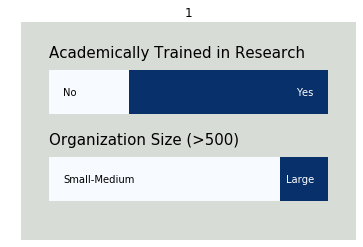

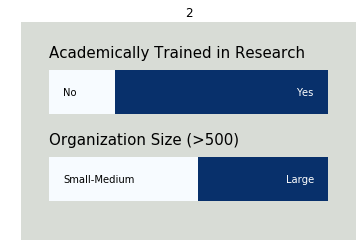

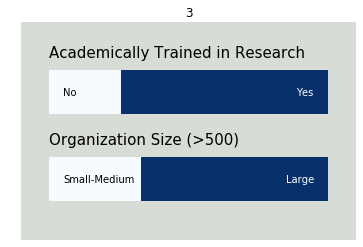

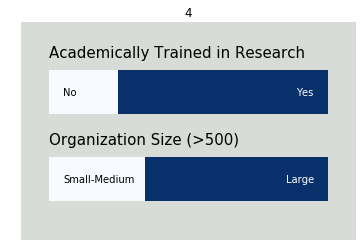

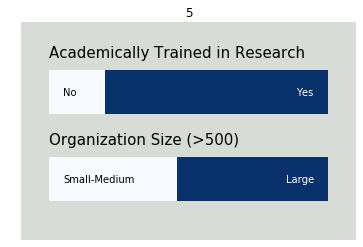

In [73]:
persona = {}
all_personas = {}
titles = ['Execs/Consult', 'Specialists', 'Very Expd', 'Med Expd', 'Less Expd']
for j in range(1,6):
    for i in [0,1]:
        persona[matricies[i].index.name] = matricies[i][j]/sum(matricies[i][j])
    all_personas[j] = pd.DataFrame(persona.copy())
for dataframe in all_personas.keys():
    ax = all_personas[dataframe].transpose().plot(kind = 'barh', stacked = True, cmap = 'Blues')
    ax.set_facecolor('xkcd:light grey')
    plt.title(dataframe)
    plt.legend().remove()
    plt.ylabel(' ')
    plt.xticks([],[])
    plt.annotate('Academically Trained in Research', (0,1.4), fontsize=15)
    plt.annotate('Organization Size (>500)',(0,.4),fontsize=15)
    plt.annotate('No',  (0.05, .96))
    plt.annotate('Yes', (.885, .96), color = 'white')
    plt.annotate('Small-Medium', (0.05,-.04))
    plt.annotate('Large', (.85,-.04), color = 'white')
    plt.yticks([],[])
    plt.ylim(-.7,1.8)
    plt.xlim(-.1,1.1)
    sns.despine(left=True, bottom=True, right=True)

    plt.savefig(f'/Users/dom/codeup_data_science/capstone/viz_files/their_personas/{dataframe}_not_pie_charts', transparent = True)

# Our new personas

- We'll be grouping this bitch on the simplest of metrics, you know why? Because it Makes good fucking sense.
- Subsets will consist of purely who are likely to attend and who are lil fucking bitches

In [74]:
#get that new mothafuckin target while it still got that new target smell
new_df = explore.add_target_to_df(df)
new_df.columns

Index(['job_title', 'job_taxo', 'job_id', 'job_conduct_res', 'job_analyze_res',
       'job_buy_res_report', 'job_manage_res_proj', 'job_observe_res',
       'job_plan_res', 'job_teach_res', 'job_advocate_res',
       'job_hire_res_vendor', 'job_lead_res_team', 'num_employees',
       'company_small', 'company_med', 'company_large', 'num_researchers',
       'num_res_small', 'num_res_med', 'num_res_large', 'primary_industry',
       'types_res_used', 'future_res', 'exp_conduct_res', 'exp_analyze_res',
       'exp_buy_res_report', 'exp_manage_res_proj', 'exp_observe_res',
       'exp_plan_res', 'exp_teach_res', 'exp_advocate_res',
       'exp_hire_res_vendor', 'exp_lead_res_team', 'research_educ',
       'research_educ_cat', 'research_educ_desc', 'learning_talks',
       'learning_read', 'learning_meetup', 'learning_workshop',
       'learning_conference', 'likely_watch_video', 'likely_internet',
       'likely_book', 'likely_online_group', 'likely_colleague',
       'likely_meetup', 'l

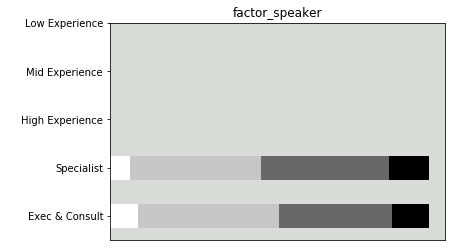

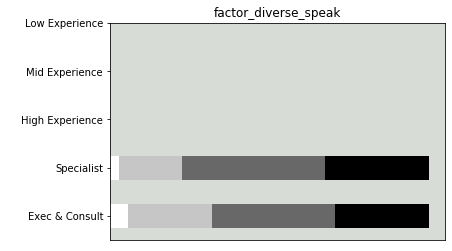

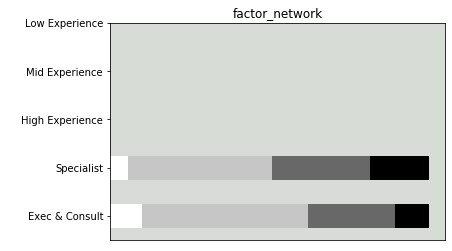

{0: targetb                0         1
 factor_speaker                    
 0               0.087571  0.061828
 1               0.443503  0.411290
 2               0.353107  0.400538
 3               0.115819  0.126344,
 1: targetb                      0         1
 factor_diverse_speak                    
 0                     0.056497  0.026882
 1                     0.262712  0.198925
 2                     0.387006  0.448925
 3                     0.293785  0.325269,
 2: targetb                0         1
 factor_network                    
 0               0.098870  0.056452
 1               0.522599  0.451613
 2               0.271186  0.306452
 3               0.107345  0.185484}

In [75]:
matricies = {}
j = 0    
for i in ['factor_speaker','factor_diverse_speak','factor_network']:
    matricies[j] = create_stacked_bars(new_df, i, return_matrix=True, grouping='targetb')
    j+=1
matricies

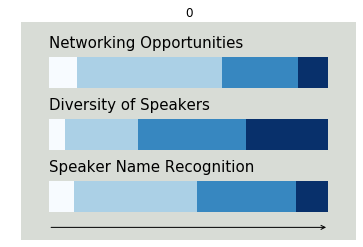

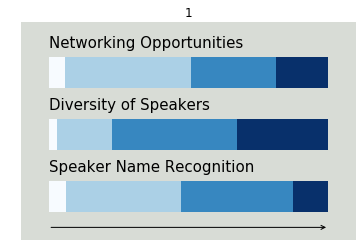

In [76]:
persona = {}
all_personas = {}
titles = ['Execs/Consult', 'Specialists', 'Very Expd', 'Med Expd', 'Less Expd']
for j in range(0,2):
    for i in [0,1,2]:
        persona[matricies[i].index.name] = matricies[i][j]
    all_personas[j] = pd.DataFrame(persona.copy())
for dataframe in all_personas.keys():
    ax = all_personas[dataframe].transpose().plot(kind = 'barh', stacked = True, cmap = 'Blues')
    ax.set_facecolor('xkcd:light grey')
    plt.title(dataframe)
    plt.legend().remove()
    plt.ylabel(' ')
    plt.xticks([],[])
    plt.annotate('Networking Opportunities', (0,2.4), fontsize=15)
    plt.annotate('Diversity of Speakers', (0,1.4), fontsize=15)
    plt.annotate('Speaker Name Recognition',(0,.4),fontsize=15)
    plt.annotate('',xy=(1 , -.5), xycoords='data',
                    xytext=(0, -.5), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3"))
    plt.yticks([],[])
    plt.ylim(-.7,2.8)
    plt.xlim(-.1,1.1)
    sns.despine(left=True, bottom=True, right=True)

    plt.savefig(f'/Users/dom/codeup_data_science/capstone/viz_files/our_personas/{dataframe}_stacked_bars', transparent = True)

In [77]:
idx = pd.IndexSlice
persona_counts = (pd.DataFrame(new_df
                               .groupby(by=['targetb'])
                               .target
                               .agg('count')
                              )
                  .rename(columns={'target': 'count'})
                 )
job_group_by = ['targetb', 'job_title']
job_counts = (pd.DataFrame(new_df
                           .groupby(by=job_group_by)
                           .target
                           .agg('count')
                          )
              .reset_index()
              .rename(columns={'target': 'count'})
              .sort_values(by=['targetb','count'], ascending=[True,False]))
job_counts = job_counts.merge(
    persona_counts.rename(columns={'count':'total'}), 
    how='left', left_on='targetb', right_on='targetb')
job_counts['pid_pct'] = np.array(job_counts['count'])/np.array(job_counts['total'])
job_counts = job_counts.drop(columns='total')
job_counts = job_counts.set_index(['targetb', 'job_title'])
for p in persona_counts.index:
    jc = job_counts.loc[idx[[p],:]].head(3).copy()
    display(jc)

count   pid_pct
targetb job_title                            
0       UX Researcher            90  0.254237
        Senior UX Researcher     46  0.129944
        UX Designer              38  0.107345

count   pid_pct
targetb job_title                            
1       UX Researcher            77  0.206989
        Senior UX Researcher     36  0.096774
        Executive                33  0.088710

unlikely
likely


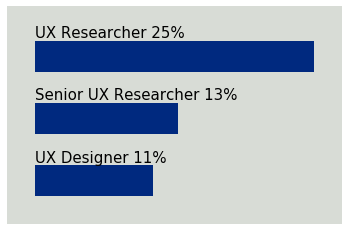

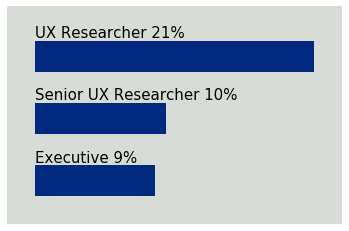

In [78]:
titles = ['unlikely','likely']

# Everyone Else Job Titles
for i in range(0,2):
    print(titles[i])
    persona_titles = []
    jc = job_counts.loc[idx[[i],:]].head(3).copy()
    jc = jc.reset_index().sort_values(by='pid_pct')
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.barh(jc.job_title, width=jc.pid_pct, height=.5, tick_label = jc.job_title, color = '#00297f')
    ax1.set_facecolor('xkcd:light grey')
    pcts = [int(round(jc["pid_pct"][0]*100)), int(round(jc["pid_pct"][1]*100)),int(round(jc["pid_pct"][2]*100))]
    plt.annotate(f'{jc.job_title[0]} {pcts[0]}%', (0,2.3), fontsize = 15)
    plt.annotate(f'{jc.job_title[1]} {pcts[1]}%', (0,1.3), fontsize = 15)
    plt.annotate(f'{jc.job_title[2]} {pcts[2]}%'  ,(0,.3), fontsize = 15)
    plt.yticks([],[])
    plt.xticks([],[])
    plt.ylim(-.7,2.8)
    plt.xlim(-.1*jc.pid_pct.max(), jc.pid_pct.max()*1.1)
    sns.despine(left=True, bottom=True, right=True)

    plt.savefig(f'/Users/dom/codeup_data_science/capstone/viz_files/our_personas/{titles[i]}_titles.png', transparent = True)

In [79]:
matricies = {}
co_size_matrix = pd.crosstab(df.targetb,df.num_employees.apply(int).apply(sm_med_large_co))
matricies[0] = co_size_matrix.transpose()
res_edu_matrix = pd.crosstab(df.targetb,df.research_educ_cat).rename(columns = {0:1,1:2})
matricies[1] = res_edu_matrix.transpose().sort_index()
matricies

{0: targetb          0    1
 num_employees          
 1.0            153  171
 2.0            200  199, 1: targetb              0    1
 research_educ_cat          
 1                   86   94
 2                  268  278}

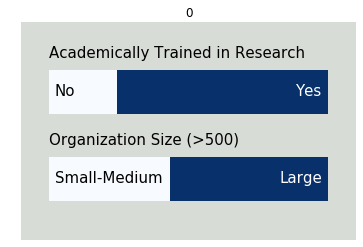

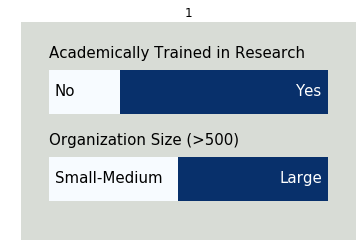

In [80]:
persona = {}
all_personas = {}
titles = ['unlikely','likley']
for j in range(0,2):
    for i in [0,1]:
        persona[matricies[i].index.name] = matricies[i][j]/sum(matricies[i][j])
    all_personas[j] = pd.DataFrame(persona.copy())
for dataframe in all_personas.keys():
    ax = all_personas[dataframe].transpose().plot(kind = 'barh', stacked = True, cmap = 'Blues')
    ax.set_facecolor('xkcd:light grey')
    plt.title(dataframe)
    plt.legend().remove()
    plt.ylabel(' ')
    plt.xticks([],[])
    plt.annotate('Academically Trained in Research', (0,1.4), fontsize=15)
    plt.annotate('Organization Size (>500)',(0,.4),fontsize=15)
    plt.annotate('No',  (0.02, .96), fontsize=15)
    plt.annotate('Yes', (.885, .96), fontsize=15, color = 'white')
    plt.annotate('Small-Medium', (0.02,-.04), fontsize=15)
    plt.annotate('Large', (.825,-.04), fontsize=15, color = 'white')
    plt.yticks([],[])
    plt.ylim(-.7,1.8)
    plt.xlim(-.1,1.1)
    sns.despine(left=True, bottom=True, right=True)

    plt.savefig(f'/Users/dom/codeup_data_science/capstone/viz_files/our_personas/{dataframe}_not_pie_charts', 
                transparent = True)

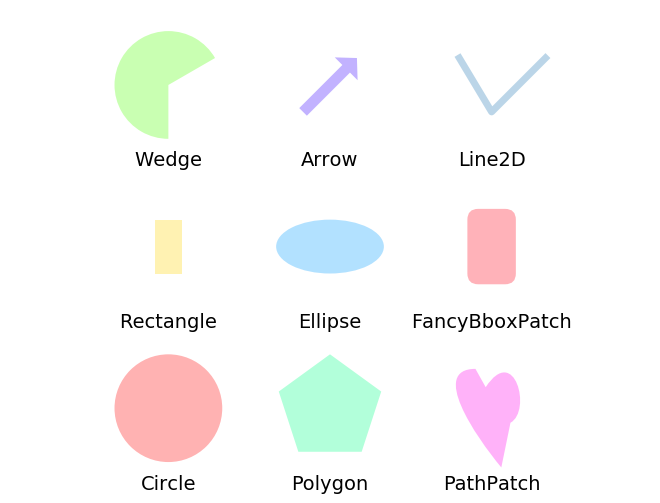

In [81]:
"""
Reference for matplotlib artists

This example displays several of matplotlib's graphics primitives (artists)
drawn using matplotlib API. A full list of artists and the documentation is
available at http://matplotlib.org/api/artist_api.html.

Copyright (c) 2010, Bartosz Telenczuk
BSD License
"""
import matplotlib.pyplot as plt
plt.rcdefaults()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection


def label(xy, text):
    y = xy[1] - 0.15  # shift y-value for label so that it's below the artist
    plt.text(xy[0], y, text, ha="center", family='sans-serif', size=14)


fig, ax = plt.subplots()
# create 3x3 grid to plot the artists
grid = np.mgrid[0.2:0.8:3j, 0.2:0.8:3j].reshape(2, -1).T

patches = []

# add a circle
circle = mpatches.Circle(grid[0], 0.1, ec="none")
patches.append(circle)
label(grid[0], "Circle")

# add a rectangle
rect = mpatches.Rectangle(grid[1] - [0.025, 0.05], 0.05, 0.1, ec="none")
patches.append(rect)
label(grid[1], "Rectangle")

# add a wedge
wedge = mpatches.Wedge(grid[2], 0.1, 30, 270, ec="none")
patches.append(wedge)
label(grid[2], "Wedge")

# add a Polygon
polygon = mpatches.RegularPolygon(grid[3], 5, 0.1)
patches.append(polygon)
label(grid[3], "Polygon")

# add an ellipse
ellipse = mpatches.Ellipse(grid[4], 0.2, 0.1)
patches.append(ellipse)
label(grid[4], "Ellipse")

# add an arrow
arrow = mpatches.Arrow(grid[5, 0] - 0.05, grid[5, 1] - 0.05, 0.1, 0.1, width=0.1)
patches.append(arrow)
label(grid[5], "Arrow")

# add a path patch
Path = mpath.Path
path_data = [
    (Path.MOVETO, [0.018, -0.11]),
    (Path.CURVE4, [-0.031, -0.051]),
    (Path.CURVE4, [-0.115,  0.073]),
    (Path.CURVE4, [-0.03 ,  0.073]),
    (Path.LINETO, [-0.011,  0.039]),
    (Path.CURVE4, [0.043,  0.121]),
    (Path.CURVE4, [0.075, -0.005]),
    (Path.CURVE4, [0.035, -0.027]),
    (Path.CLOSEPOLY, [0.018, -0.11])
    ]
codes, verts = zip(*path_data)
path = mpath.Path(verts + grid[6], codes)
patch = mpatches.PathPatch(path)
patches.append(patch)
label(grid[6], "PathPatch")

# add a fancy box
fancybox = mpatches.FancyBboxPatch(
    grid[7] - [0.025, 0.05], 0.05, 0.1,
    boxstyle=mpatches.BoxStyle("Round", pad=0.02))
patches.append(fancybox)
label(grid[7], "FancyBboxPatch")

# add a line
x, y = np.array([[-0.06, 0.0, 0.1], [0.05, -0.05, 0.05]])
line = mlines.Line2D(x + grid[8, 0], y + grid[8, 1], lw=5., alpha=0.3)
label(grid[8], "Line2D")

colors = np.linspace(0, 1, len(patches))
collection = PatchCollection(patches, cmap=plt.cm.hsv, alpha=0.3)
collection.set_array(np.array(colors))
ax.add_collection(collection)
ax.add_line(line)

plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.axis('equal')
plt.axis('off')

plt.show()


In [105]:
def money_a_factor(x):
    if x in [2,3,4]:
        return 1
    if x in [0,1]:
        return 2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


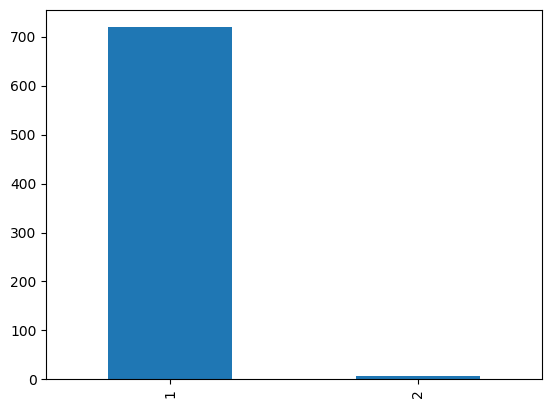

In [106]:
df.factor_topics.apply(money_a_factor).value_counts().plot('bar')

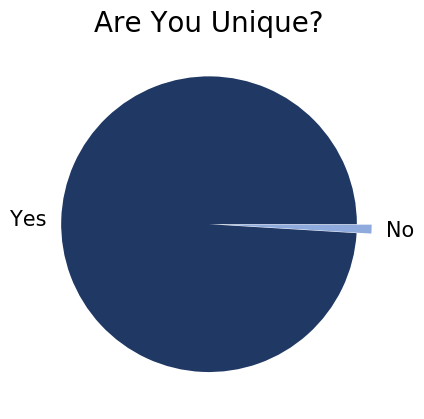

In [143]:
ax = df.factor_topics.apply(money_a_factor).value_counts().plot.pie(explode = (0,.1), labels = ['Yes','No'],fontsize = 15, colors = ['#1f3864','#8faadc'])
plt.ylabel('')
plt.title('Are You Unique?', fontsize = 20)
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color(None)
ax.spines['top'].set_color(None)


plt.show()

In [104]:
df.fact

False

In [ ]:
pd.crosstab()

In [119]:
pd.crosstab(new_df.likely_conference.apply(money_a_factor), df.likely_workshop.apply(money_a_factor))

likely_workshop,1,2
likely_conference,,
1,463,58
2,85,120
